* pertama buat cross validation buat modelnya
* grid search optimal parameter
* feature ablation dengan nambahin parameter baru ke function generate feature berupa feature mana yang mau dihilangkan dari dictionary
* error analysis tapi belum tau

In [23]:
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
import scipy
from pathlib import Path


In [34]:
scic

'1.0.0'

In [24]:
def read_data(data_path):
    data = open(data_path, 'r').read()
    data = data.split('\n\n')
    tagged_sentences = []

    for sentence in data:
        tagged_sentences.append(list(tuple(word_tag.split('\t')) for word_tag in sentence.split('\n')))
    
    return tagged_sentences

In [25]:
data_path = "data/Indonesian_Manually_Tagged_Corpus.tsv"
tagged_sentences = read_data(data_path)

In [26]:
print("Number of Tagged Sentences ", len(tagged_sentences))
tagged_words = [tup for sent in tagged_sentences for tup in sent]
print("Total Number of Tagged words", len(tagged_words))
vocab = set([word for word, tag in tagged_words])
print("Vocabulary of the Corpus", len(vocab))
tags = set([tag for word, tag in tagged_words])
print("Number of Tags in the Corpus ", len(tags))

Number of Tagged Sentences  10030
Total Number of Tagged words 256622
Vocabulary of the Corpus 18287
Number of Tags in the Corpus  24


In [27]:
train_set, test_set = train_test_split(tagged_sentences, test_size=0.2, random_state=42)
print("Number of Sentences in Training Data ", len(train_set))
print("Number of Sentences in Testing Data ", len(test_set))

Number of Sentences in Training Data  8024
Number of Sentences in Testing Data  2006


In [28]:
def features(sentence, index):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    return {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index == 0),
        'is_last_word':int(index == len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
        'prev_word':'' if index == 0 else sentence[index-1],
        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
         }
  
def untag(sentence):
    return [word for word, tag in sentence]


def prepareData(tagged_sentences):
    X, y = [], []
    for sentences in tagged_sentences:
        X.append([features(untag(sentences), index) for index in range(len(sentences))])
        y.append([tag for word, tag in sentences])
    return X, y

X_train, y_train = prepareData(train_set)
X_test, y_test = prepareData(test_set)

## First Model Iteration

In [29]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.01, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [11]:
# cv_results = cross_validate(crf, X_train, y_train, cv=3, return_train_score=False)

In [31]:
y_pred = crf.predict(X_test)
y_pred_train = crf.predict(X_train)

### precision, recall, and F1 scores

In [32]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

         IN      0.963     0.968     0.965      4096
         NN      0.970     0.974     0.972     12316
         JJ      0.949     0.948     0.948      1972
         PR      0.997     0.995     0.996      1111
          Z      0.998     0.998     0.998      5211
         CD      0.995     0.993     0.994      3591
        SYM      1.000     0.991     0.995       428
         VB      0.990     0.988     0.989      6371
         CC      0.988     0.979     0.983      1552
         RB      0.977     0.960     0.968      1007
         MD      0.993     0.985     0.989      1054
        PRP      0.997     0.994     0.996      1549
        NNP      0.951     0.964     0.958      6661
         SC      0.949     0.957     0.953      2601
        NND      0.939     0.906     0.922       255
         FW      0.916     0.810     0.860       458
        NEG      0.993     0.997     0.995       287
          X      0.800     0.434     0.562   

#### Confusion Matrix

In [14]:
import itertools

def flatten(ls):
    return list(itertools.chain.from_iterable(ls))

Confusion matrix, without normalization


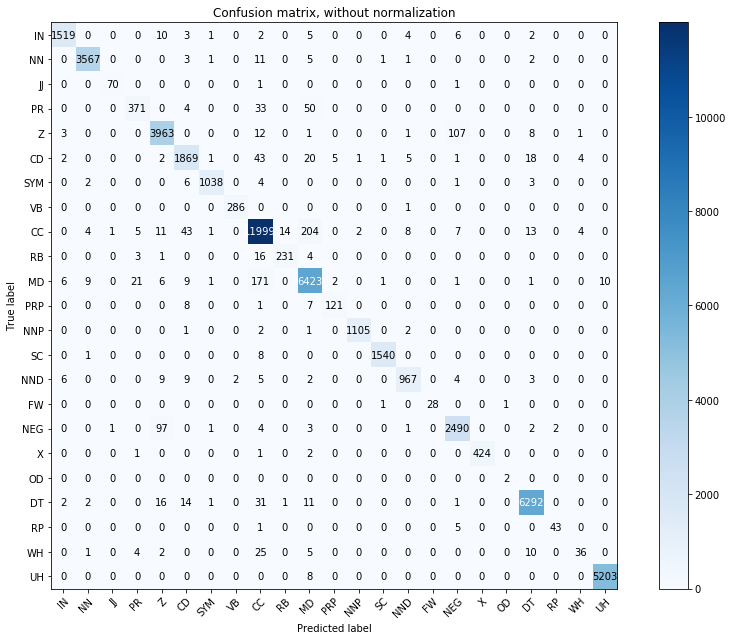

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(12, 9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  
plot_confusion_matrix(flatten(y_test), flatten(y_pred), classes=crf.classes_,
                      title='Confusion matrix, without normalization');

#### Feature Ablation

In [17]:
def feature_ablation(d, entriesToRemove = None):
    for k in entriesToRemove:
        d.pop(k, None)
    return d
      
def features(sentence, index, entriesToRemove = None):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    ### and entriestoRemove type is tuple
    d = {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index == 0),
        'is_last_word':int(index == len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper() == sentence[index]),
        'prev_word':'' if index == 0 else sentence[index-1],
        'next_word':'' if index == len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])', sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0 
         }
    
    if not entriesToRemove:
        return d
    else:
        return feature_ablation(d, entriesToRemove)
                
def untag(sentence):
      return [word for word, tag in sentence]


def prepareData(tagged_sentences):
    X, y = [], []
    entriesToRemove = tuple(['suffix_1', 'suffix_2', 'suffix_3', 'suffix_4'])
    for sentences in tagged_sentences:
        X.append([features(untag(sentences), index, entriesToRemove) for index in range(len(sentences))])
        y.append([tag for word, tag in sentences])
    return X, y

X_train, y_train = prepareData(train_set)
X_test, y_test = prepareData(test_set)

In [18]:
crf.fit(X_train, y_train)

y_pred = crf.predict(X_test)
y_pred_train = crf.predict(X_train)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ANTHONI\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


             precision    recall  f1-score   support

         IN      0.941     0.944     0.942      4096
         NN      0.944     0.954     0.949     12316
         JJ      0.879     0.855     0.867      1972
         PR      0.982     0.993     0.987      1111
          Z      0.998     0.998     0.998      5211
         CD      0.979     0.978     0.978      3591
        SYM      1.000     0.991     0.995       428
         VB      0.963     0.968     0.965      6371
         CC      0.984     0.963     0.974      1552
         RB      0.929     0.886     0.907      1007
         MD      0.983     0.982     0.982      1054
        PRP      0.985     0.988     0.986      1549
        NNP      0.945     0.961     0.953      6661
         SC      0.937     0.937     0.937      2601
        NND      0.929     0.878     0.903       255
         FW      0.892     0.718     0.796       458
        NEG      0.983     0.986     0.984       287
          X      0.655     0.229     0.339   

#### Previous Metrics Used

In [0]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=crf.classes_)

0.9724534681067327

In [0]:
metrics.flat_f1_score(y_train, y_pred_train, average='weighted', labels=crf.classes_)

0.9945989057594046

In [0]:
metrics.flat_accuracy_score(y_test, y_pred)

0.9726862168931312

In [0]:
metrics.flat_accuracy_score(y_train, y_pred_train)

0.9946048580558065

In [0]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

              precision    recall  f1-score   support

          VB      0.991     0.988     0.989      6283
          CD      0.993     0.992     0.992      3587
          NN      0.969     0.974     0.971     12439
          IN      0.958     0.969     0.963      4160
          PR      0.997     0.993     0.995      1089
           Z      0.998     0.998     0.998      5200
          CC      0.988     0.977     0.983      1483
          MD      0.995     0.985     0.990      1034
          SC      0.948     0.949     0.949      2597
          JJ      0.943     0.944     0.944      1945
         PRP      0.999     0.992     0.995      1484
          RB      0.981     0.963     0.972       980
         NNP      0.947     0.960     0.953      6550
          FW      0.901     0.791     0.842       473
         NEG      0.993     0.993     0.993       282
         SYM      0.998     0.993     0.995       439
         NND      0.953     0.901     0.926       292
          OD      0.917    

## Hyperparameter Optimization

In [0]:
# labels = crf.classes_

# # define fixed parameters and parameters to search
# crf = CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(metrics.flat_f1_score,
#                         average='weighted', labels=labels)

# # search
# rs = RandomizedSearchCV(crf, params_space,
#                         cv=3,
#                         verbose=1,
#                         n_jobs=-1,
#                         n_iter=50,
#                         scoring=f1_scorer)
# rs.fit(X_train, y_train)

NameError: ignored

In [0]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [0]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [0]:
y_pred = crf.predict(X_test)

In [0]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=crf.classes_)

0.9724534681067327

In [0]:
y_pred_train = crf.predict(X_train)
metrics.flat_f1_score(y_train, y_pred_train, average='weighted', labels=crf.classes_)

0.9945989057594046

In [0]:
metrics.flat_accuracy_score(y_test, y_pred)

0.9726862168931312

In [0]:
metrics.flat_accuracy_score(y_train, y_pred_train)

0.9946048580558065

In [0]:
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

              precision    recall  f1-score   support

          VB      0.991     0.988     0.989      6283
          CD      0.993     0.992     0.992      3587
          NN      0.969     0.974     0.971     12439
          IN      0.958     0.969     0.963      4160
          PR      0.997     0.993     0.995      1089
           Z      0.998     0.998     0.998      5200
          CC      0.988     0.977     0.983      1483
          MD      0.995     0.985     0.990      1034
          SC      0.948     0.949     0.949      2597
          JJ      0.943     0.944     0.944      1945
         PRP      0.999     0.992     0.995      1484
          RB      0.981     0.963     0.972       980
         NNP      0.947     0.960     0.953      6550
          FW      0.901     0.791     0.842       473
         NEG      0.993     0.993     0.993       282
         SYM      0.998     0.993     0.995       439
         NND      0.953     0.901     0.926       292
          OD      0.917    

## Exploratory

In [0]:
tags = [tag for word, tag in tagged_words]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
plt.style.use('ggplot')
%matplotlib inline

In [0]:
keys, counts = np.unique(tags, return_counts=True)
c = Counter(tag for _, tag in tagged_words)
c.most_common()

<BarContainer object of 24 artists>

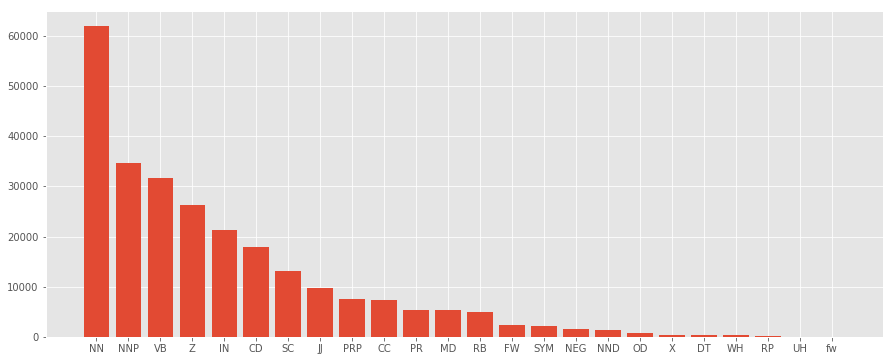

In [0]:
tags, counts = zip(*c.most_common())
plt.figure(figsize=(15, 6))
plt.bar(range(len(tags)), counts, tick_label=tags)

In [0]:
Counter(crf.transition_features_).most_common(20)

[(('FW', 'FW'), 5.430697),
 (('NNP', 'NNP'), 5.027061),
 (('NN', 'NN'), 3.128899),
 (('CD', 'NND'), 2.899531),
 (('NND', 'NN'), 2.735116),
 (('NN', 'JJ'), 2.60922),
 (('FW', 'X'), 2.573882),
 (('VB', 'NN'), 2.377382),
 (('CD', 'NN'), 2.262913),
 (('IN', 'NN'), 2.188129),
 (('MD', 'VB'), 2.154137),
 (('RB', 'JJ'), 1.967941),
 (('NND', 'NND'), 1.959163),
 (('NN', 'FW'), 1.85816),
 (('DT', 'NN'), 1.825163),
 (('SC', 'NN'), 1.711053),
 (('PRP', 'VB'), 1.685623),
 (('X', 'X'), 1.681162),
 (('NN', 'X'), 1.680572),
 (('SC', 'VB'), 1.644478)]

In [0]:
Counter(crf.transition_features_).most_common()[-20:]

[(('NEG', 'RP'), -1.485512),
 (('NEG', 'PRP'), -1.498597),
 (('NEG', 'CC'), -1.504881),
 (('SC', 'CC'), -1.541169),
 (('CD', 'NEG'), -1.559034),
 (('NEG', 'NNP'), -1.591638),
 (('CC', 'OD'), -1.612649),
 (('MD', 'PR'), -1.667278),
 (('RB', 'CC'), -1.710736),
 (('IN', 'NEG'), -1.720364),
 (('NNP', 'WH'), -1.734328),
 (('SC', 'OD'), -1.785886),
 (('PRP', 'NND'), -1.972032),
 (('WH', 'IN'), -2.019842),
 (('IN', 'IN'), -2.065791),
 (('PRP', 'PRP'), -2.098119),
 (('WH', 'MD'), -2.104171),
 (('MD', 'SC'), -2.598032),
 (('IN', 'CC'), -2.635035),
 (('IN', 'MD'), -3.125608)]

In [0]:
Counter(crf.state_features_).most_common(20)

[(('suffix_4:mnya', 'SC'), 7.288268),
 (('suffix_4:mang', 'RB'), 6.808271),
 (('prefix_4:bers', 'IN'), 6.669543),
 (('suffix_4:rsen', 'CD'), 5.775705),
 (('prefix_3:ber', 'VB'), 5.737055),
 (('suffix_4:gkah', 'NN'), 5.735885),
 (('is_first_capital', 'NNP'), 5.550816),
 (('is_complete_capital', 'Z'), 5.045144),
 (('suffix_4:lasa', 'NNP'), 4.883297),
 (('prefix_4:berb', 'CD'), 4.88048),
 (('prefix_2:di', 'VB'), 4.834333),
 (('suffix_4:adak', 'RB'), 4.811211),
 (('suffix_4:urut', 'IN'), 4.783329),
 (('suffix_4:agai', 'IN'), 4.781865),
 (('suffix_4:esar', 'JJ'), 4.744588),
 (('prefix_4:dana', 'NN'), 4.735894),
 (('prefix_4:kura', 'RB'), 4.70777),
 (('suffix_4:rsih', 'JJ'), 4.691708),
 (('prefix_4:sama', 'JJ'), 4.636071),
 (('suffix_4:enai', 'IN'), 4.630181)]

In [0]:
metrics.flat_classification_report()